# © Copyright 2020 [AAAASTARK](https://github.com/aaaastark).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aaaastark/Pretrain_Finetune_Transformers_Pytorch/blob/master/FineTune_Transformers_Pytorch.ipynb) &nbsp;
[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch/blob/master/FineTune_Transformers_Pytorch.ipynb)
[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

# **Fine-tune Transformers in PyTorch Using Hugging Face Transformers**  

> **Fine-tune transformers models for classification tasks**

## Overview

This guide aims to demonstrate how to fine-tune a pre-trained transformers model for classification tasks. The tutorial primarily focuses on the code implementation and its adaptability to various needs.

We utilize the [AutoClasses](https://huggingface.co/transformers/model_doc/auto.html) feature from the [transformers](https://github.com/huggingface/transformers) library by [Hugging Face](https://huggingface.co/). This functionality enables automatic detection of a model's configuration, tokenizer, and architecture based solely on the model's name. This flexibility allows easy reusability across a wide range of transformers models.

<br>

## Prerequisites

This notebook is designed to be accessible with basic Python coding knowledge. Familiarity with PyTorch and the [transformers](https://github.com/huggingface/transformers) library would be beneficial.

<br>

## How to Utilize This Notebook

This notebook is structured for reusability. Loading the dataset into the PyTorch class follows a standard procedure and can be readily adapted for other datasets.

To use your own dataset, modifications are required in the dataset loading section within the PyTorch **Dataset** class under the **Dataset and DataLoader** tab. The **DataLoader** returns batch inputs in a dictionary format suitable for direct feeding into the model with the statement: `outputs = model(**batch)`. As long as this statement holds true, the remaining code will function seamlessly.

Basic parameters defined under the **Imports** tab include:
* `epochs`: Number of epochs for training the model. Typically 2-3 epochs suffice.
* `batch_size`: Batch size for training. Larger batches consume more memory; decrease batch size if encountering CUDA Out Of Memory (OOM) errors.
* `max_length`: Optional parameter for truncating text inputs to a shorter length than the maximum allowed word piece tokens sequence length, potentially expediting training.
* `model_name_or_path`: Location of the transformer model to be trained. Starting with `bert-base-cased` is recommended.
* `labels_ids`: Mapping of label names to IDs, facilitating label association within the PyTorch Dataset class.

<br>

## Supported Transformers Models

This notebook is designed to accommodate various transformer models beyond just BERT for classification tasks.

A comprehensive test was conducted across [all the pretrained models](https://huggingface.co/transformers/pretrained_models.html#pretrained-models) available on Hugging Face Transformer. This ensured compatibility with a wide range of models without necessitating modifications.

Out of the tested models, **73 models** were successfully integrated, while **33 models** exhibited compatibility issues with this notebook.

<br>

## Dataset

This notebook focuses on fine-tuning transformers for a binary classification task, using the well-known Large Movie Review Dataset for sentiment analysis. This dataset comprises 25,000 polar movie reviews for training and an additional 25,000 for testing.

According to the Stanford website:

*This dataset offers substantial data for binary sentiment classification, surpassing previous benchmark datasets. It includes 25,000 highly polar movie reviews for training and an equivalent set for testing. Additional unlabeled data is also provided.*

**Rationale**: The Large Movie Review Dataset is selected for its simplicity and familiarity, making it ideal for classification tasks. Sentiment analysis is inherently engaging, adding to the appeal of this dataset.

# Downloads

Download the *Large Movie Review Dataset* and unzip it locally.


In [ ]:
# Download the dataset.
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip the dataset.
!tar -zxf /content/aclImdb_v1.tar.gz

# Installs

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version I will install it straight from GitHub.

* **[Pretrain_Finetune_Transformers_Pytorch](https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch)** library used for various transformers related tasks. I created this library to reduce the amount of code I need to write for each transformers project.


In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch.git

# Imports

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from pretrain_finetune_transformers_pytorch import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )


# Set seed for reproducibility,
set_seed(123)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Number of batch_size - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'bert-base-cased'

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# Helper Functions

I like to keep all Classes and functions that will be used in this notebook under this section to help maintain a clean look of the notebook:

* MovieReviewsDataset
* train
* validation

In [ ]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens and where the text gets encoded using
  loaded tokenizer.

  This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer used to process raw text into numbers.

    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to
        labels names and Values map to number associated to those labels.

    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer and model.

  """

  def __init__(self, path, use_tokenizer, labels_ids, max_sequence_len=None):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    # Check max sequence length.
    max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
    texts = []
    labels = []
    print('Reading partitions...')
    # Since the labels are defined by folders with data we loop
    # through each label.
    for label, label_id,  in tqdm(labels_ids.items()):
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      print('Reading %s files...' % label)
      # Go through each file and read its content.
      for file_name in tqdm(files_names):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        texts.append(content)
        # Save encode labels.
        labels.append(label_id)

    # Number of exmaples.
    self.n_examples = len(labels)
    # Use tokenizer on texts. This can take a while.
    print('Using tokenizer on all texts. This can take a while...')
    self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
    # Get maximum sequence length.
    self.sequence_len = self.inputs['input_ids'].shape[-1]
    print('Texts padded or truncated to %d length!' % self.sequence_len)
    # Add labels.
    self.inputs.update({'labels':torch.tensor(labels)})
    print('Finished!\n')

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
      It holddes the statement `model(**Returned Dictionary)`.

    """

    return {key: self.inputs[key][item] for key in self.inputs.keys()}



def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load Model and Tokenizer

Loding the three esential parts of pretrained transformers: configuration, tokenizer and model. We also need to load model to the device we're planning to use (GPU / CPU).

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [ ]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train',
                               use_tokenizer=tokenizer,
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test',
                               use_tokenizer=tokenizer,
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Reading partitions...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `train_dataset` with 25000 examples!
Created `train_dataloader` with 782 batches!

Dealing with ...
Reading partitions...


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `valid_dataset` with 25000 examples!
Created `eval_dataloader` with 782 batches!


# Train

Create optimizer and scheduler use by PyTorch in training.

Loop through the number of defined epochs and call the **train** and **validation** functions.

Outputs similar info after each epoch as in Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.44681 - val_loss: 0.38175 - train_acc: 0.78368 - valid_acc: 0.82360


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.29189 - val_loss: 0.40589 - train_acc: 0.87568 - valid_acc: 0.82632


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.17021 - val_loss: 0.52414 - train_acc: 0.93476 - valid_acc: 0.82676


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.09729 - val_loss: 0.68216 - train_acc: 0.96736 - valid_acc: 0.82488



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


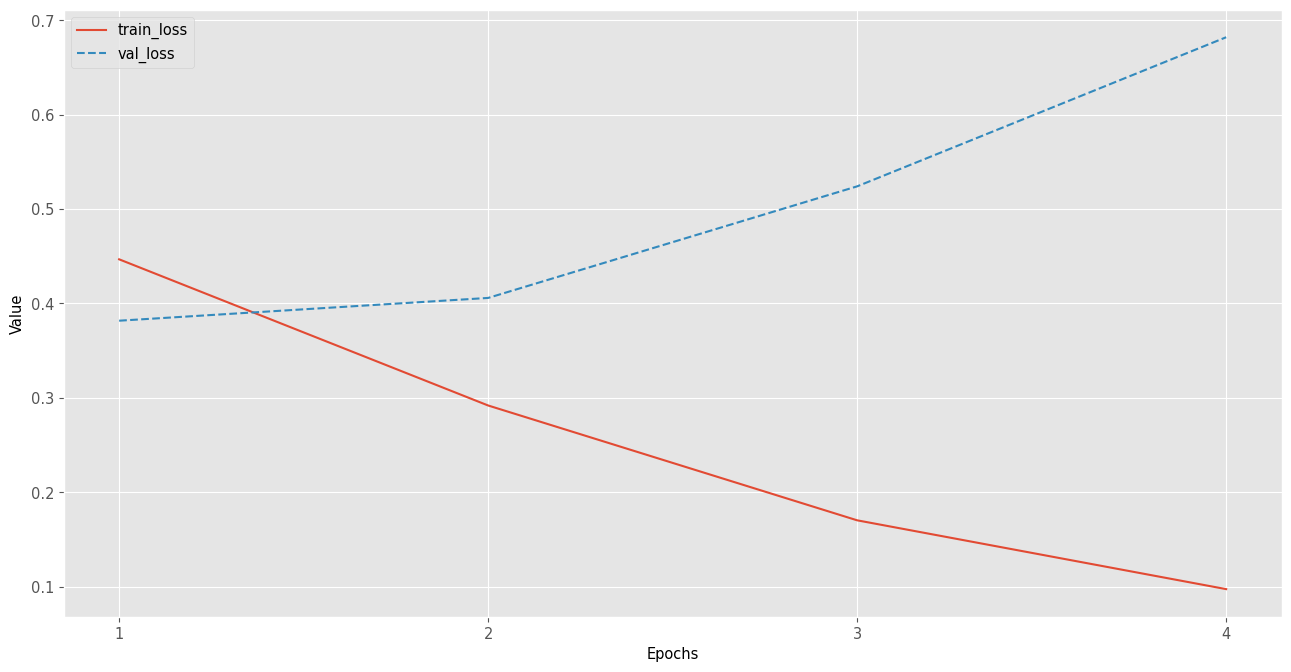

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


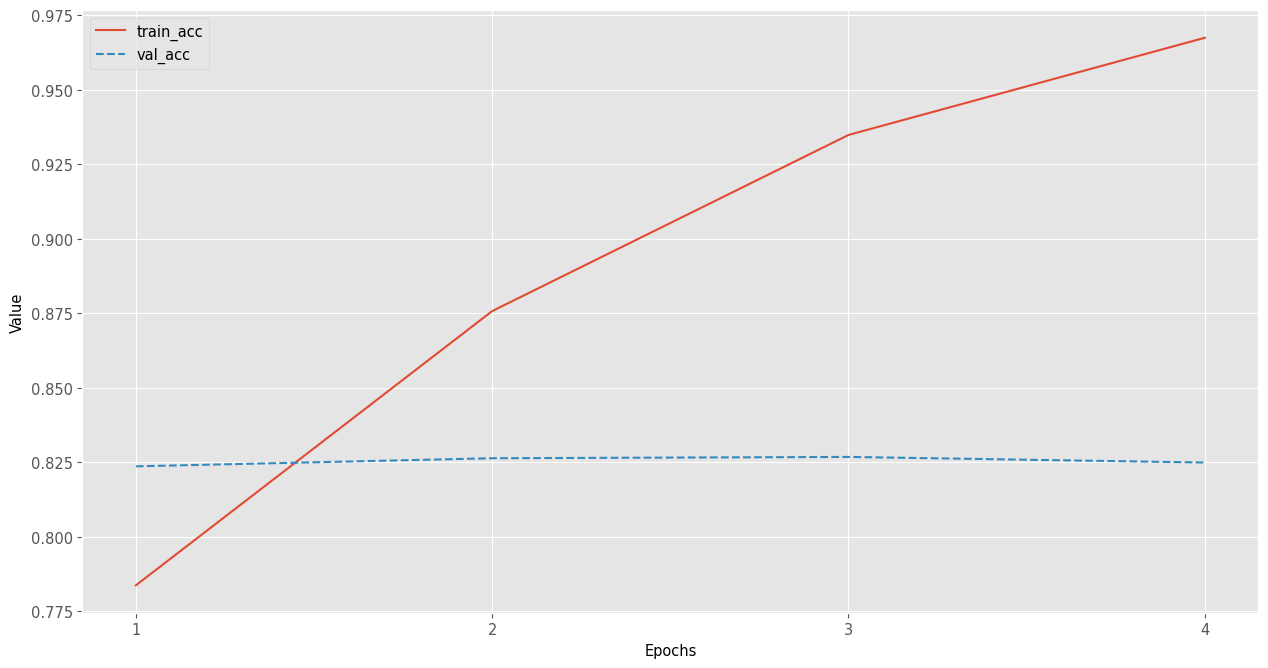

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluate

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

              precision    recall  f1-score   support

         neg       0.83      0.82      0.82     12500
         pos       0.82      0.83      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Normalized confusion matrix


/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:676: DeprecationWarning: `magnify` needs to have value in [0,1]! `3` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


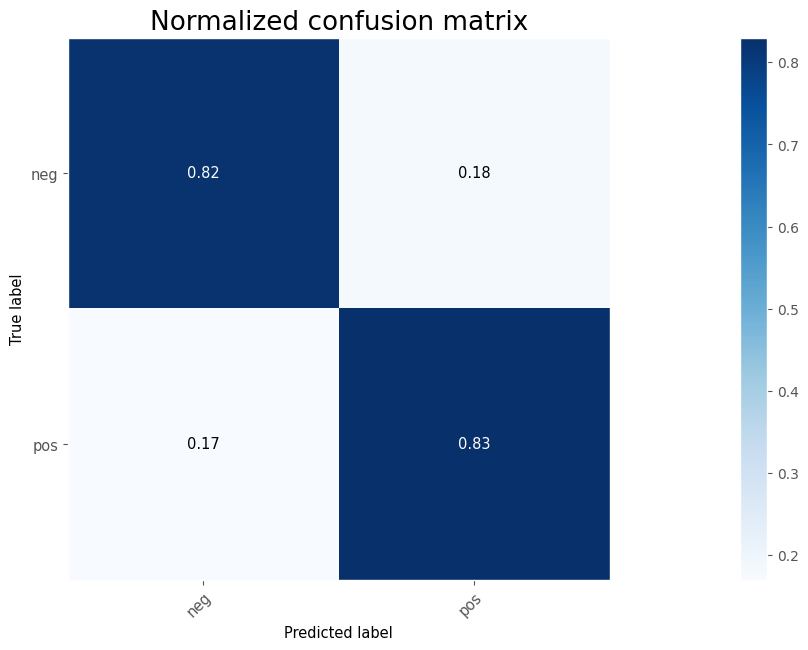

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=3,
                      );

# Pretrained models that work with **Fine Tune Transformers with Pytorch**

|Status|Architecture|Shortcut name|
 |:-|:-|:-|
 |Worked|BERT|bert-base-uncased|
 |Worked|BERT|bert-large-uncased|
 |Worked|BERT|bert-base-cased|
 |Worked|BERT|bert-large-cased|
 |Worked|BERT|bert-base-multilingual-uncased|
 |Worked|BERT|bert-base-multilingual-cased|
 |Worked|BERT|bert-base-chinese|
 |Worked|BERT|bert-base-german-cased|
 |Worked|BERT|bert-large-uncased-whole-word-masking|
 |Worked|BERT|bert-large-cased-whole-word-masking|
 |Worked|BERT|bert-large-uncased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-large-cased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-base-cased-finetuned-mrpc|
 |Worked|BERT|bert-base-german-dbmdz-cased|
 |Worked|BERT|bert-base-german-dbmdz-uncased|
 |Failed|BERT|cl-tohoku/bert-base-japanese|
 |Failed|BERT|cl-tohoku/bert-base-japanese-whole-word-masking|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char-whole-word-masking|
 |Worked|BERT|TurkuNLP/bert-base-finnish-cased-v1|
 |Worked|BERT|TurkuNLP/bert-base-finnish-uncased-v1|
 |Worked|BERT|wietsedv/bert-base-dutch-cased|
 |Failed|GPT|openai-gpt|
 |Failed|GPT-2|gpt2|
 |Failed|GPT-2|gpt2-medium|
 |Failed|GPT-2|gpt2-large|
 |Failed|GPT-2|gpt2-xl|
 |Failed|Transformer-XL|transfo-xl-wt103|
 |Worked|XLNet|xlnet-base-cased|
 |Worked|XLNet|xlnet-large-cased|
 |Worked|XLM|xlm-mlm-en-2048|
 |Worked|XLM|xlm-mlm-ende-1024|
 |Worked|XLM|xlm-mlm-enfr-1024|
 |Worked|XLM|xlm-mlm-enro-1024|
 |Worked|XLM|xlm-mlm-xnli15-1024|
 |Worked|XLM|xlm-mlm-tlm-xnli15-1024|
 |Worked|XLM|xlm-clm-enfr-1024|
 |Worked|XLM|xlm-clm-ende-1024|
 |Worked|XLM|xlm-mlm-17-1280|
 |Failed|XLM|xlm-mlm-100-1280|
 |Worked|RoBERTa|roberta-base|
 |Worked|RoBERTa|roberta-large|
 |Failed|RoBERTa|roberta-large-mnli|
 |Worked|RoBERTa|distilroberta-base|
 |Worked|RoBERTa|roberta-base-openai-detector|
 |Worked|RoBERTa|roberta-large-openai-detector|
 |Worked|DistilBERT|distilbert-base-uncased|
 |Worked|DistilBERT|distilbert-base-uncased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-cased|
 |Worked|DistilBERT|distilbert-base-cased-distilled-squad|
 |Failed|DistilBERT|distilgpt2|
 |Worked|DistilBERT|distilbert-base-german-cased|
 |Worked|DistilBERT|distilbert-base-multilingual-cased|
 |Failed|CTRL|ctrl|
 |Worked|CamemBERT|camembert-base|
 |Worked|ALBERT|albert-base-v1|
 |Worked|ALBERT|albert-large-v1|
 |Worked|ALBERT|albert-xlarge-v1|
 |Worked|ALBERT|albert-xxlarge-v1|
 |Worked|ALBERT|albert-base-v2|
 |Worked|ALBERT|albert-large-v2|
 |Worked|ALBERT|albert-xlarge-v2|
 |Worked|ALBERT|albert-xxlarge-v2|
 |Failed|T5|t5-small|
 |Failed|T5|t5-base|
 |Failed|T5|t5-large|
 |Failed|T5|t5-3B|
 |Failed|T5|t5-11B|
 |Worked|XLM-RoBERTa|xlm-roberta-base|
 |Worked|XLM-RoBERTa|xlm-roberta-large|
 |Worked|FlauBERT|flaubert/flaubert_small_cased|
 |Worked|FlauBERT|flaubert/flaubert_base_uncased|
 |Worked|FlauBERT|flaubert/flaubert_base_cased|
 |Worked|FlauBERT|flaubert/flaubert_large_cased|
 |Worked|Bart|facebook/bart-large|
 |Worked|Bart|facebook/bart-base|
 |Failed|Bart|facebook/bart-large-mnli|
 |Worked|Bart|facebook/bart-large-cnn|
 |Failed|DialoGPT|DialoGPT-small|
 |Failed|DialoGPT|DialoGPT-medium|
 |Failed|DialoGPT|DialoGPT-large|
 |Failed|Reformer|reformer-enwik8|
 |Failed|Reformer|reformer-crime-and-punishment|
 |Failed|MarianMT|Helsinki-NLP/opus-mt-{src}-{tgt}|
 |Failed|Pegasus|google/pegasus-{dataset}|
 |Worked|Longformer|allenai/longformer-base-4096|
 |Worked|Longformer|allenai/longformer-large-4096|
 |Failed|MBart|facebook/mbart-large-cc25|
 |Failed|MBart|facebook/mbart-large-en-ro|
 |Failed|Lxmert|lxmert-base-uncased|
 |Worked|Funnel Transformer|funnel-transformer/small|
 |Worked|Funnel Transformer|funnel-transformer/small-base|
 |Worked|Funnel Transformer|funnel-transformer/medium|
 |Worked|Funnel Transformer|funnel-transformer/medium-base|
 |Worked|Funnel Transformer|funnel-transformer/intermediate|
 |Worked|Funnel Transformer|funnel-transformer/intermediate-base|
 |Worked|Funnel Transformer|funnel-transformer/large|
 |Worked|Funnel Transformer|funnel-transformer/large-base|
 |Worked|Funnel Transformer|funnel-transformer/xlarge|
 |Worked|Funnel Transformer|funnel-transformer/xlarge-base|
 |Failed|LayoutLM|microsoft/layoutlm-base-uncased|
 |Failed|LayoutLM|microsoft/layoutlm-large-uncased|
 |Worked|DeBERTa|microsoft/deberta-base|
 |Worked|DeBERTa|microsoft/deberta-large|
 |Worked|SqueezeBERT|squeezebert/squeezebert-uncased|
 |Failed|SqueezeBERT|squeezebert/squeezebert-mnli|
 |Worked|BERT|bert-base-uncased|
 |Worked|BERT|bert-large-uncased|
 |Worked|BERT|bert-base-cased|
 |Worked|BERT|bert-large-cased|
 |Worked|BERT|bert-base-multilingual-uncased|
 |Worked|BERT|bert-base-multilingual-cased|
 |Worked|BERT|bert-base-chinese|
 |Worked|BERT|bert-base-german-cased|
 |Worked|BERT|bert-large-uncased-whole-word-masking|
 |Worked|BERT|bert-large-cased-whole-word-masking|
 |Worked|BERT|bert-large-uncased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-large-cased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-base-cased-finetuned-mrpc|
 |Worked|BERT|bert-base-german-dbmdz-cased|
 |Worked|BERT|bert-base-german-dbmdz-uncased|
 |Failed|BERT|cl-tohoku/bert-base-japanese|
 |Failed|BERT|cl-tohoku/bert-base-japanese-whole-word-masking|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char-whole-word-masking|
 |Worked|BERT|TurkuNLP/bert-base-finnish-cased-v1|
 |Worked|BERT|TurkuNLP/bert-base-finnish-uncased-v1|
 |Worked|BERT|wietsedv/bert-base-dutch-cased|
 |Failed|GPT|openai-gpt|
 |Failed|GPT-2|gpt2|
 |Failed|GPT-2|gpt2-medium|
 |Failed|GPT-2|gpt2-large|
 |Failed|GPT-2|gpt2-xl|
 |Failed|Transformer-XL|transfo-xl-wt103|
 |Worked|XLNet|xlnet-base-cased|
 |Worked|XLNet|xlnet-large-cased|
 |Worked|XLM|xlm-mlm-en-2048|
 |Worked|XLM|xlm-mlm-ende-1024|
 |Worked|XLM|xlm-mlm-enfr-1024|
 |Worked|XLM|xlm-mlm-enro-1024|
 |Worked|XLM|xlm-mlm-xnli15-1024|
 |Worked|XLM|xlm-mlm-tlm-xnli15-1024|
 |Worked|XLM|xlm-clm-enfr-1024|
 |Worked|XLM|xlm-clm-ende-1024|
 |Worked|XLM|xlm-mlm-17-1280|
 |Failed|XLM|xlm-mlm-100-1280|
 |Worked|RoBERTa|roberta-base|
 |Worked|RoBERTa|roberta-large|
 |Failed|RoBERTa|roberta-large-mnli|
 |Worked|RoBERTa|distilroberta-base|
 |Worked|RoBERTa|roberta-base-openai-detector|
 |Worked|RoBERTa|roberta-large-openai-detector|
 |Worked|DistilBERT|distilbert-base-uncased|
 |Worked|DistilBERT|distilbert-base-uncased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-cased|
 |Worked|DistilBERT|distilbert-base-cased-distilled-squad|
 |Failed|DistilBERT|distilgpt2|
 |Worked|DistilBERT|distilbert-base-german-cased|
 |Worked|DistilBERT|distilbert-base-multilingual-cased|
 |Failed|CTRL|ctrl|
 |Worked|CamemBERT|camembert-base|
 |Worked|ALBERT|albert-base-v1|
 |Worked|ALBERT|albert-large-v1|
 |Worked|ALBERT|albert-xlarge-v1|
 |Worked|ALBERT|albert-xxlarge-v1|
 |Worked|ALBERT|albert-base-v2|
 |Worked|ALBERT|albert-large-v2|
 |Worked|ALBERT|albert-xlarge-v2|
 |Worked|ALBERT|albert-xxlarge-v2|
 |Failed|T5|t5-small|
 |Failed|T5|t5-base|
 |Failed|T5|t5-large|
 |Failed|T5|t5-3B|
 |Failed|T5|t5-11B|
 |Worked|XLM-RoBERTa|xlm-roberta-base|
 |Worked|XLM-RoBERTa|xlm-roberta-large|
 |Worked|FlauBERT|flaubert/flaubert_small_cased|
 |Worked|FlauBERT|flaubert/flaubert_base_uncased|
 |Worked|FlauBERT|flaubert/flaubert_base_cased|
 |Worked|FlauBERT|flaubert/flaubert_large_cased|
 |Worked|Bart|facebook/bart-large|
 |Worked|Bart|facebook/bart-base|
 |Failed|Bart|facebook/bart-large-mnli|
 |Worked|Bart|facebook/bart-large-cnn|
 |Failed|DialoGPT|DialoGPT-small|
 |Failed|DialoGPT|DialoGPT-medium|
 |Failed|DialoGPT|DialoGPT-large|
 |Failed|Reformer|reformer-enwik8|
 |Failed|Reformer|reformer-crime-and-punishment|
 |Failed|MarianMT|Helsinki-NLP/opus-mt-{src}-{tgt}|
 |Failed|Pegasus|google/pegasus-{dataset}|
 |Worked|Longformer|allenai/longformer-base-4096|
 |Worked|Longformer|allenai/longformer-large-4096|
 |Failed|MBart|facebook/mbart-large-cc25|
 |Failed|MBart|facebook/mbart-large-en-ro|
 |Failed|Lxmert|lxmert-base-uncased|
 |Worked|Funnel Transformer|funnel-transformer/small|
 |Worked|Funnel Transformer|funnel-transformer/small-base|
 |Worked|Funnel Transformer|funnel-transformer/medium|
 |Worked|Funnel Transformer|funnel-transformer/medium-base|
 |Worked|Funnel Transformer|funnel-transformer/intermediate|
 |Worked|Funnel Transformer|funnel-transformer/intermediate-base|
 |Worked|Funnel Transformer|funnel-transformer/large|
 |Worked|Funnel Transformer|funnel-transformer/large-base|
 |Worked|Funnel Transformer|funnel-transformer/xlarge|
 |Worked|Funnel Transformer|funnel-transformer/xlarge-base|
 |Failed|LayoutLM|microsoft/layoutlm-base-uncased|
 |Failed|LayoutLM|microsoft/layoutlm-large-uncased|
 |Worked|DeBERTa|microsoft/deberta-base|
 |Worked|DeBERTa|microsoft/deberta-large|
 |Worked|SqueezeBERT|squeezebert/squeezebert-uncased|
 |Failed|SqueezeBERT|squeezebert/squeezebert-mnli|
 |Worked|BERT|bert-base-uncased|
 |Worked|BERT|bert-large-uncased|
 |Worked|BERT|bert-base-cased|
 |Worked|BERT|bert-large-cased|
 |Worked|BERT|bert-base-multilingual-uncased|
 |Worked|BERT|bert-base-multilingual-cased|
 |Worked|BERT|bert-base-chinese|
 |Worked|BERT|bert-base-german-cased|
 |Worked|BERT|bert-large-uncased-whole-word-masking|
 |Worked|BERT|bert-large-cased-whole-word-masking|
 |Worked|BERT|bert-large-uncased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-large-cased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-base-cased-finetuned-mrpc|
 |Worked|BERT|bert-base-german-dbmdz-cased|
 |Worked|BERT|bert-base-german-dbmdz-uncased|
 |Failed|BERT|cl-tohoku/bert-base-japanese|
 |Failed|BERT|cl-tohoku/bert-base-japanese-whole-word-masking|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char-whole-word-masking|
 |Worked|BERT|TurkuNLP/bert-base-finnish-cased-v1|
 |Worked|BERT|TurkuNLP/bert-base-finnish-uncased-v1|
 |Worked|BERT|wietsedv/bert-base-dutch-cased|
 |Failed|GPT|openai-gpt|
 |Failed|GPT-2|gpt2|
 |Failed|GPT-2|gpt2-medium|
 |Failed|GPT-2|gpt2-large|
 |Failed|GPT-2|gpt2-xl|
 |Failed|Transformer-XL|transfo-xl-wt103|
 |Worked|XLNet|xlnet-base-cased|
 |Worked|XLNet|xlnet-large-cased|
 |Worked|XLM|xlm-mlm-en-2048|
 |Worked|XLM|xlm-mlm-ende-1024|
 |Worked|XLM|xlm-mlm-enfr-1024|
 |Worked|XLM|xlm-mlm-enro-1024|
 |Worked|XLM|xlm-mlm-xnli15-1024|
 |Worked|XLM|xlm-mlm-tlm-xnli15-1024|
 |Worked|XLM|xlm-clm-enfr-1024|
 |Worked|XLM|xlm-clm-ende-1024|
 |Worked|XLM|xlm-mlm-17-1280|
 |Failed|XLM|xlm-mlm-100-1280|
 |Worked|RoBERTa|roberta-base|
 |Worked|RoBERTa|roberta-large|
 |Failed|RoBERTa|roberta-large-mnli|
 |Worked|RoBERTa|distilroberta-base|
 |Worked|RoBERTa|roberta-base-openai-detector|
 |Worked|RoBERTa|roberta-large-openai-detector|
 |Worked|DistilBERT|distilbert-base-uncased|
 |Worked|DistilBERT|distilbert-base-uncased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-cased|
 |Worked|DistilBERT|distilbert-base-cased-distilled-squad|
 |Failed|DistilBERT|distilgpt2|
 |Worked|DistilBERT|distilbert-base-german-cased|
 |Worked|DistilBERT|distilbert-base-multilingual-cased|
 |Failed|CTRL|ctrl|
 |Worked|CamemBERT|camembert-base|
 |Worked|ALBERT|albert-base-v1|
 |Worked|ALBERT|albert-large-v1|
 |Worked|ALBERT|albert-xlarge-v1|
 |Worked|ALBERT|albert-xxlarge-v1|
 |Worked|ALBERT|albert-base-v2|
 |Worked|ALBERT|albert-large-v2|
 |Worked|ALBERT|albert-xlarge-v2|
 |Worked|ALBERT|albert-xxlarge-v2|
 |Failed|T5|t5-small|
 |Failed|T5|t5-base|
 |Failed|T5|t5-large|
 |Failed|T5|t5-3B|
 |Failed|T5|t5-11B|
 |Worked|XLM-RoBERTa|xlm-roberta-base|
 |Worked|XLM-RoBERTa|xlm-roberta-large|
 |Worked|FlauBERT|flaubert/flaubert_small_cased|
 |Worked|FlauBERT|flaubert/flaubert_base_uncased|
 |Worked|FlauBERT|flaubert/flaubert_base_cased|
 |Worked|FlauBERT|flaubert/flaubert_large_cased|
 |Worked|Bart|facebook/bart-large|
 |Worked|Bart|facebook/bart-base|
 |Failed|Bart|facebook/bart-large-mnli|
 |Worked|Bart|facebook/bart-large-cnn|
 |Failed|DialoGPT|DialoGPT-small|
 |Failed|DialoGPT|DialoGPT-medium|
 |Failed|DialoGPT|DialoGPT-large|
 |Failed|Reformer|reformer-enwik8|
 |Failed|Reformer|reformer-crime-and-punishment|
 |Failed|MarianMT|Helsinki-NLP/opus-mt-{src}-{tgt}|
 |Failed|Pegasus|google/pegasus-{dataset}|
 |Worked|Longformer|allenai/longformer-base-4096|
 |Worked|Longformer|allenai/longformer-large-4096|
 |Failed|MBart|facebook/mbart-large-cc25|
 |Failed|MBart|facebook/mbart-large-en-ro|
 |Failed|Lxmert|lxmert-base-uncased|
 |Worked|Funnel Transformer|funnel-transformer/small|
 |Worked|Funnel Transformer|funnel-transformer/small-base|
 |Worked|Funnel Transformer|funnel-transformer/medium|
 |Worked|Funnel Transformer|funnel-transformer/medium-base|
 |Worked|Funnel Transformer|funnel-transformer/intermediate|
 |Worked|Funnel Transformer|funnel-transformer/intermediate-base|
 |Worked|Funnel Transformer|funnel-transformer/large|
 |Worked|Funnel Transformer|funnel-transformer/large-base|
 |Worked|Funnel Transformer|funnel-transformer/xlarge|
 |Worked|Funnel Transformer|funnel-transformer/xlarge-base|
 |Failed|LayoutLM|microsoft/layoutlm-base-uncased|
 |Failed|LayoutLM|microsoft/layoutlm-large-uncased|
 |Worked|DeBERTa|microsoft/deberta-base|
 |Worked|DeBERTa|microsoft/deberta-large|
 |Worked|SqueezeBERT|squeezebert/squeezebert-uncased|
 |Failed|SqueezeBERT|squeezebert/squeezebert-mnli|
 |Worked|BERT|bert-base-uncased|
 |Worked|BERT|bert-large-uncased|
 |Worked|BERT|bert-base-cased|
 |Worked|BERT|bert-large-cased|
 |Worked|BERT|bert-base-multilingual-uncased|
 |Worked|BERT|bert-base-multilingual-cased|
 |Worked|BERT|bert-base-chinese|
 |Worked|BERT|bert-base-german-cased|
 |Worked|BERT|bert-large-uncased-whole-word-masking|
 |Worked|BERT|bert-large-cased-whole-word-masking|
 |Worked|BERT|bert-large-uncased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-large-cased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-base-cased-finetuned-mrpc|
 |Worked|BERT|bert-base-german-dbmdz-cased|
 |Worked|BERT|bert-base-german-dbmdz-uncased|
 |Worked|BERT|TurkuNLP/bert-base-finnish-cased-v1|
 |Worked|BERT|TurkuNLP/bert-base-finnish-uncased-v1|
 |Worked|BERT|wietsedv/bert-base-dutch-cased|
 |Worked|XLNet|xlnet-base-cased|
 |Worked|XLNet|xlnet-large-cased|
 |Worked|XLM|xlm-mlm-en-2048|
 |Worked|XLM|xlm-mlm-ende-1024|
 |Worked|XLM|xlm-mlm-enfr-1024|
 |Worked|XLM|xlm-mlm-enro-1024|
 |Worked|XLM|xlm-mlm-xnli15-1024|
 |Worked|XLM|xlm-mlm-tlm-xnli15-1024|
 |Worked|XLM|xlm-clm-enfr-1024|
 |Worked|XLM|xlm-clm-ende-1024|
 |Worked|XLM|xlm-mlm-17-1280|
 |Worked|RoBERTa|roberta-base|
 |Worked|RoBERTa|roberta-large|
 |Worked|RoBERTa|distilroberta-base|
 |Worked|RoBERTa|roberta-base-openai-detector|
 |Worked|RoBERTa|roberta-large-openai-detector|
 |Worked|DistilBERT|distilbert-base-uncased|
 |Worked|DistilBERT|distilbert-base-uncased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-cased|
 |Worked|DistilBERT|distilbert-base-cased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-german-cased|
 |Worked|DistilBERT|distilbert-base-multilingual-cased|
 |Worked|CamemBERT|camembert-base|
 |Worked|ALBERT|albert-base-v1|
 |Worked|ALBERT|albert-large-v1|
 |Worked|ALBERT|albert-xlarge-v1|
 |Worked|ALBERT|albert-xxlarge-v1|
 |Worked|ALBERT|albert-base-v2|
 |Worked|ALBERT|albert-large-v2|
 |Worked|ALBERT|albert-xlarge-v2|
 |Worked|ALBERT|albert-xxlarge-v2|
 |Worked|XLM-RoBERTa|xlm-roberta-base|
 |Worked|XLM-RoBERTa|xlm-roberta-large|
 |Worked|FlauBERT|flaubert/flaubert_small_cased|
 |Worked|FlauBERT|flaubert/flaubert_base_uncased|
 |Worked|FlauBERT|flaubert/flaubert_base_cased|
 |Worked|FlauBERT|flaubert/flaubert_large_cased|
 |Worked|Bart|facebook/bart-large|
 |Worked|Bart|facebook/bart-base|
 |Worked|Bart|facebook/bart-large-cnn|
 |Worked|Longformer|allenai/longformer-base-4096|
 |Worked|Longformer|allenai/longformer-large-4096|
 |Worked|Funnel Transformer|funnel-transformer/small|
 |Worked|Funnel Transformer|funnel-transformer/small-base|
 |Worked|Funnel Transformer|funnel-transformer/medium|
 |Worked|Funnel Transformer|funnel-transformer/medium-base|
 |Worked|Funnel Transformer|funnel-transformer/intermediate|
 |Worked|Funnel Transformer|funnel-transformer/intermediate-base|
 |Worked|Funnel Transformer|funnel-transformer/large|
 |Worked|Funnel Transformer|funnel-transformer/large-base|
 |Worked|Funnel Transformer|funnel-transformer/xlarge|
 |Worked|Funnel Transformer|funnel-transformer/xlarge-base|
 |Worked|DeBERTa|microsoft/deberta-base|
 |Worked|DeBERTa|microsoft/deberta-large|
 |Worked|SqueezeBERT|squeezebert/squeezebert-uncased|